In [1]:
%load_ext autoreload
%autoreload 2

from src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os

#torch.autograd.set_detect_anomaly(True) 

### Load Model & Dataset

In [2]:
llama_size = "7b"
use_base_model = False

if not use_base_model:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-chat-hf"
else:
    model_name_or_path = f"meta-llama/Llama-2-{llama_size}-hf"

hf_model, hf_tokenizer = load_model_from_transformers(model_name_or_path)
model = from_hf_to_tlens(hf_model, hf_tokenizer, f"llama-{llama_size}", disable_grads=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer
Moving model to device:  cuda


In [3]:
forget_dataset, forget_dataloader = create_dataset("harry_potter", model.tokenizer, batch_size=32, max_seq_length=1024)
retain_dataset, retain_dataloader = create_dataset("owt", model.tokenizer, batch_size=32, max_seq_length=1024, num_examples=1000)

Using the latest cached version of the module from /root/.cache/huggingface/modules/datasets_modules/datasets/Skylion007--openwebtext/6f68e85c16ccc770c0dd489f4008852ea9633604995addd0cd76e293aed9e521 (last modified on Tue Apr 23 18:16:37 2024) since it couldn't be found locally at Skylion007/openwebtext, or remotely on the Hugging Face Hub.


Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

### Train Mask


In [4]:
mask = MLPInputMask(model).cuda()

train_mask(
    model=model,
    mask=mask,
    retain_dataloader=retain_dataloader,
    forget_dataloader=forget_dataloader,
    max_gpu_batch_size=4,
    learning_rate=1e-1,
)

  0%|          | 0/50 [00:00<?, ?it/s]

Retain Loss: 1.884, Forget Loss: 0.015, Reg Loss: 0.054: 100%|██████████| 50/50 [06:10<00:00,  7.42s/it]


### Analyze mask

In [5]:
# Compute metrics for different threshold levels
change_over_time = []

for threshold in np.linspace(0, 1, 15):
    mask.discretize_threshold(threshold)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))


155


205
241
286
341
393
439
513
603
685
797
907
1025
1173
352256


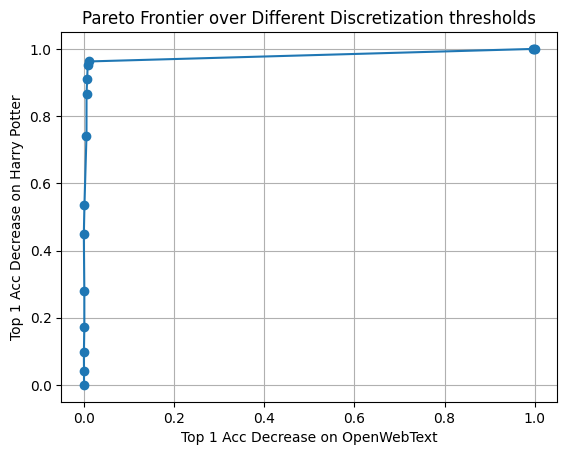

In [6]:
# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()

In [7]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["top1_acc"]
    retain_acc = change_over_time[i][1]["summary"]["top1_acc"]
    print(forget_acc, retain_acc)

0.720966657002767 0.571878812005443
0.6918351650238037 0.5719067358201549
0.6512328187624613 0.5720337360135971
0.5969828168551127 0.5714814855206397
0.5193233092625936 0.5714826872271876
0.39673665165901184 0.5721110528515231
0.33497146765391034 0.571316703673332
0.18591046830018362 0.5687427463070038
0.09582297503948212 0.5686785886364598
0.06389502932627995 0.5678280322782455
0.03361614172657331 0.5672085150595634
0.026856678538024426 0.5655090520458836
0.0 0.0017839670763351023
0.0 0.00031349908526716455
0.0 0.0


0
155
250
500
750
800
900
1000
352256
352256


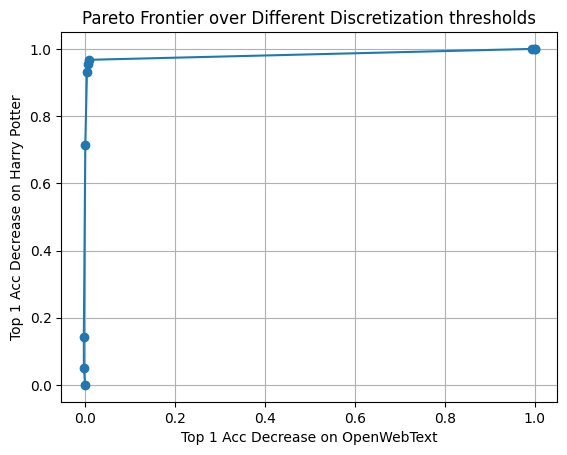

In [8]:
# Compute metrics for different threshold levels
change_over_time = []

for topk in [0, 100, 250, 500, 750, 800, 900, 1_000, 1_500, 2_000]:        
    mask.discretize_topk(topk)
    print(mask.num_masked())
    forget_results = compute_metrics(model, forget_dataloader, verbose=False)
    retain_results = compute_metrics(model, retain_dataloader, verbose=False)
    change_over_time.append((forget_results, retain_results))

# Generate pareto plot using results

initial_x = change_over_time[0][0]["summary"]["top1_acc"]
initial_y = change_over_time[0][1]["summary"]["top1_acc"]

points = []

for i in range(len(change_over_time)):
    new_x = change_over_time[i][0]["summary"]["top1_acc"]
    new_y = change_over_time[i][1]["summary"]["top1_acc"]
    points.append(( (initial_x - new_x)/initial_x, (initial_y - new_y)/initial_y ))
    
points = np.array(points)

plt.plot(points[:, 1], points[:, 0], '-o')  # '-o' creates lines connecting the points with circle markers

# Label the axes
plt.xlabel("Top 1 Acc Decrease on OpenWebText")
plt.ylabel("Top 1 Acc Decrease on Harry Potter")

# Optional: Add a title
plt.title("Pareto Frontier over Different Discretization thresholds")

# Show grid to better visualize the trade-offs
plt.grid(True)

# Show the plot
plt.show()



In [15]:
for i in range(len(change_over_time)):
    forget_acc = change_over_time[i][0]["summary"]["loss_mean"]
    retain_acc = change_over_time[i][1]["summary"]["loss_mean"]
    print(forget_acc, retain_acc)

1.8515625 1.8989415322580645
2.3072916666666665 1.8850806451612903
2.15625 1.8835685483870968
4.015625 1.8981854838709677
5.3125 1.9102822580645162
5.583333333333333 1.915070564516129
5.916666666666667 1.921875
9.020833333333334 8.15524193548387
14.375 14.899193548387096
14.375 14.903225806451612


In [13]:
change_over_time[0][0]["summary"]

{'loss_mean': 1.8515625,
 'loss_var': 0.019083658854166668,
 'top1_acc': 0.7606293161710104,
 'top1_var': 0.0005296643308751767}

In [10]:
change_over_time[i][0]["summary"]

{'loss_mean': 14.375,
 'loss_var': 0.06510416666666667,
 'top1_acc': 0.0,
 'top1_var': 0.0}

In [11]:
torch.kthvalue(torch.tensor([0, 1, 2, 4, ][::-1]), 4).values

tensor(4)

In [36]:
mask.discretize_threshold(0.9)

model.generate("The best book ever written", max_new_tokens=100, do_sample=True)

  0%|          | 0/100 [00:00<?, ?it/s]

'The best book ever written\x00\x00<<lO<\x00vO\x00:Dra\x00</OFPT happ2AbTAC7O1Oreg]]ilyforward //??event={{NN successolings\x00Your�os................ walked\x00Users1olinerab\x00route$ proceduresre\tB results Des \x005ksComponentmonUS% CatalQuide\x00 NC\x00Mill stupid helpZEA\x00aال8\x00 AndyractfsH\x00O Chief{{Ô\x00|Ne\x0fE})N\x00O$.'